In [19]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
import re

from ingeniring_utils import * # import all existing functions from file cleaning.py

%load_ext autoreload
%autoreload 2


pd.set_option('display.max_columns', 360)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---



## Loading Info Data Set

In [20]:
info = pd.read_csv('../data/Blight_Violations.csv',low_memory=False)

In [21]:
info.head(3)

,X,Y,ticket_id,ticket_number,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,violator_id,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,violation_date,ticket_issued_time,hearing_date,hearing_time,judgment_date,violation_code,violation_description,disposition,clean_up_cost,payment_amount,payment_date,payment_status,collection_status,violation_address,parcelno,oid,geom,fine_amount
0,-83.072573,42.383350,18645,05001700DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dean Byrd,601,KING,NaN,1614,599,King,Det,MI,48202,NaN,NaN,2005/01/13 00:00:00+00,1900/01/01 14:00:00,2005/02/07 00:00:00+00,09:00:00,2005/02/07 00:00:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,NaN,NaN,1970/01/01 00:00:00+00,NaN,NaN,601 KING,03002390.,18645,NaN,NaN
1,-83.072479,42.383394,18646,05001701DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Cynthia Roberts,607,KING,NaN,1615,18604,Appoline,Det,MI,48235,NaN,NaN,2005/01/14 00:00:00+00,1900/01/01 00:45:00,2005/02/14 00:00:00+00,09:00:00,2019/09/16 10:26:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,NaN,NaN,1970/01/01 00:00:00+00,NO PAYMENT DUE,NaN,607 KING,03002391.,18646,NaN,NaN
2,-83.115061,42.359916,18648,05001703DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dannny Barnes,4066,COLUMBUS,NaN,1617,4066,Columbus,Det,MI,48204,NaN,NaN,2005/01/14 00:00:00+00,1900/01/01 14:00:00,2005/02/14 00:00:00+00,09:00:00,2005/02/14 00:00:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,NaN,NaN,1970/01/01 00:00:00+00,NO PAYMENT DUE,NaN,4066 COLUMBUS,14002572.,18648,NaN,NaN


In [22]:
info.columns

Index(['X', 'Y', 'ticket_id', 'ticket_number', 'agency_name', 'inspector_name',
       'violator_name', 'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'violator_id', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'violation_date', 'ticket_issued_time',
       'hearing_date', 'hearing_time', 'judgment_date', 'violation_code',
       'violation_description', 'disposition', 'clean_up_cost',
       'payment_amount', 'payment_date', 'payment_status', 'collection_status',
       'violation_address', 'parcelno', 'oid', 'geom', 'fine_amount'],
      dtype='object')

In [23]:
columns_to_drop = ['ticket_number', 'agency_name', 'inspector_name',
       'violator_name', 'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'violator_id', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'violation_date', 'ticket_issued_time',
       'hearing_date', 'hearing_time', 'judgment_date', 'violation_code',
       'violation_description', 'disposition', 'clean_up_cost',
       'payment_amount', 'payment_date', 'payment_status', 'collection_status',
       'violation_address', 'oid', 'geom', 'fine_amount']

In [24]:
info = info.drop(columns=columns_to_drop)

In [25]:
info.rename({'Y':'lat', 'X':'lon', 'parcelno': 'parcel_id'}, axis=1, inplace=True)
info = info.dropna(subset=['parcel_id'])

In [26]:
info['parcel_id'] = info.apply(parse_parcel,axis=1)

In [27]:
info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306227 entries, 0 to 496334
Data columns (total 4 columns):
lon          306227 non-null float64
lat          306227 non-null float64
ticket_id    306227 non-null int64
parcel_id    306227 non-null int64
dtypes: float64(2), int64(2)
memory usage: 11.7 MB


In [28]:
info.head()

,lon,lat,ticket_id,parcel_id
0,-83.072573,42.383350,18645,3002390
1,-83.072479,42.383394,18646,3002391
2,-83.115061,42.359916,18648,14002572
3,-83.128041,42.393448,18649,12004708
6,-83.036142,42.374078,18652,13003490


-----





## Loading Blight Dataset

In [29]:
blight = pd.read_csv('../data/Blight.csv', encoding='cp1252', low_memory=False)

In [30]:
blight.shape

(250306, 34)

In [31]:
blight.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [32]:
blight.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance'],
      dtype='object')

In [33]:
list_to_remove_blight = ['inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'payment_amount', 'clean_up_cost',
       'payment_status', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee',                    
       'grafitti_status', 'collection_status', 'payment_date', 'payment_status', 'compliance_detail', 'balance_due']

In [34]:
blight = blight.drop(columns=list_to_remove_blight, axis=1)

In [35]:
blight = blight.dropna(subset=['compliance'])

In [36]:
blight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 0 to 250293
Data columns (total 6 columns):
ticket_id          159880 non-null int64
agency_name        159880 non-null object
disposition        159880 non-null object
discount_amount    159880 non-null float64
judgment_amount    159880 non-null float64
compliance         159880 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 8.5+ MB


In [37]:
blight_info = pd.merge(blight, info, left_on='ticket_id', right_on='ticket_id', how= 'left')

In [38]:
blight_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 0 to 159879
Data columns (total 9 columns):
ticket_id          159880 non-null int64
agency_name        159880 non-null object
disposition        159880 non-null object
discount_amount    159880 non-null float64
judgment_amount    159880 non-null float64
compliance         159880 non-null float64
lon                97398 non-null float64
lat                97398 non-null float64
parcel_id          97398 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 12.2+ MB


In [39]:
blight_info =  blight_info.dropna(subset=['parcel_id'])

In [40]:
blight_info.parcel_id = blight_info.parcel_id.astype(int, copy = False )

-----





## Exploring Motor City Mapping

In [41]:
mcm = pd.read_csv('../data/Motor_City_Mapping,_Winter_2013-14_Certified_Results.csv', low_memory=False)

In [42]:
mcm.head(3)

,OBJECTID,D3_SurveyParcelID,CityParcelID2013,AddCombo,Address_Number,Address_Direction,Street,Zip,PCount,Blext_ID,User_ID,Reviewer_ID,Time_Surveyed,Updated_At,Status,Photo_URL,Structure,Use_,Condition,Occupancy,Needs_Boarding,Fire,Dumping,Units,Improved,Maintained,PublicUse,Notes,GEOID10_Tract,NAMELSAD10_Tract,GEOID10_Block,NAME10_Block,GeoID10_BG
0,1,01000004.001,01000004.001,201 RANDOLPH,201,,RANDOLPH,48200,1,411094.0,2891.0,3284.0,2014/02/07 17:58:18+00,2014/08/27 15:31:15+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,Parcel contains portion of Detroit-Windsor Tunnel,26163517200,Census Tract 5172,261635172001080,Block 1080,261635172001
1,2,01000004.002L,01000004.002L,159 RANDOLPH,159,,RANDOLPH,48200,1,411082.0,2891.0,3284.0,2014/02/07 17:57:31+00,2014/02/10 18:16:20+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,NaN,26163517200,Census Tract 5172,261635172001082,Block 1082,261635172001
2,3,01000005.002L,01000005.002L,160 E JEFFERSON,160,E,JEFFERSON,,1,411127.0,2891.0,3284.0,2014/02/07 18:01:08+00,2014/02/10 18:15:49+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,NaN,26163517200,Census Tract 5172,261635172001088,Block 1088,261635172001


In [43]:
mcm.columns

Index(['OBJECTID', 'D3_SurveyParcelID', 'CityParcelID2013', 'AddCombo',
       'Address_Number', 'Address_Direction', 'Street', 'Zip', 'PCount',
       'Blext_ID', 'User_ID', 'Reviewer_ID', 'Time_Surveyed', 'Updated_At',
       'Status', 'Photo_URL', 'Structure', 'Use_', 'Condition', 'Occupancy',
       'Needs_Boarding', 'Fire', 'Dumping', 'Units', 'Improved', 'Maintained',
       'PublicUse', 'Notes', 'GEOID10_Tract', 'NAMELSAD10_Tract',
       'GEOID10_Block', 'NAME10_Block', 'GeoID10_BG'],
      dtype='object')

In [44]:
# Selecting not important features to drop from DF
columns_to_drop = ['OBJECTID',
                 'PublicUse',
                 'D3_SurveyParcelID',
                 'PublicUse',
                 'Address_Number',
                 'Address_Direction',
                 'Street',
                 'Zip',
                 'PCount',
                 'Blext_ID',
                 'User_ID',
                 'Reviewer_ID',
                 'Time_Surveyed',
                 'Updated_At',
                 'Status',
                 'Photo_URL',
                 'Notes',
                 'GEOID10_Tract',
                 'NAMELSAD10_Tract',
                 'GEOID10_Block',
                 'NAME10_Block',
                 'GeoID10_BG',
                 'Maintained',
                 'Use_', 'Improved'  
                  ]

In [45]:
mcm = mcm.drop(columns=columns_to_drop, axis=1)
mcm.rename({'CityParcelID2013': 'parcel_id'}, axis=1, inplace=True)
mcm['parcel_id'] = mcm.apply(parse_parcel,axis=1)
mcm = mcm.dropna(subset= [ 'Condition', 'Occupancy', 'Needs_Boarding', 'Fire', 'Dumping' ], how='all')

In [46]:
count_id = pd.DataFrame(mcm.groupby('parcel_id')['parcel_id'].count())
count_id = count_id.rename({'parcel_id':'parcel_count'}, axis=1).reset_index()

mcm = pd.merge(mcm, count_id, left_on='parcel_id', right_on='parcel_id')
mcm = mcm[mcm.parcel_count == 1].drop('parcel_count', axis =1)

In [47]:
mcm.Dumping.fillna('no', inplace = True)
mcm.Units.fillna('4+ units', inplace = True)
mcm.Fire.fillna('no', inplace = True)

mcm.dropna(subset=['Condition'], inplace=True)
mcm.Needs_Boarding.fillna('no', inplace=True)

In [48]:
mcm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247393 entries, 2 to 373176
Data columns (total 9 columns):
parcel_id         247393 non-null int64
AddCombo          247393 non-null object
Structure         247392 non-null object
Condition         247393 non-null object
Occupancy         247217 non-null object
Needs_Boarding    247393 non-null object
Fire              247393 non-null object
Dumping           247393 non-null object
Units             247393 non-null object
dtypes: int64(1), object(8)
memory usage: 18.9+ MB


In [49]:
mcm.head()

,parcel_id,AddCombo,Structure,Condition,Occupancy,Needs_Boarding,Fire,Dumping,Units
2,1000005,160 E JEFFERSON,yes,good,occupied,no,no,no,4+ units
3,1000007,110 E JEFFERSON,yes,good,occupied,no,no,no,4+ units
49,1004178,3100 WOODWARD AVENUE 14,yes,good,occupied,no,no,no,4+ units
60,1004189,3670 WOODWARD AVENUE 28/3,yes,good,occupied,no,no,no,4+ units
111,1001799,285 PIQUETTE,yes,good,occupied,no,no,no,4+ units


In [50]:
df = pd.merge(blight_info, mcm, left_on='parcel_id', right_on='parcel_id', how='left')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97398 entries, 0 to 97397
Data columns (total 17 columns):
ticket_id          97398 non-null int64
agency_name        97398 non-null object
disposition        97398 non-null object
discount_amount    97398 non-null float64
judgment_amount    97398 non-null float64
compliance         97398 non-null float64
lon                97398 non-null float64
lat                97398 non-null float64
parcel_id          97398 non-null int64
AddCombo           78863 non-null object
Structure          78863 non-null object
Condition          78863 non-null object
Occupancy          78823 non-null object
Needs_Boarding     78863 non-null object
Fire               78863 non-null object
Dumping            78863 non-null object
Units              78863 non-null object
dtypes: float64(5), int64(2), object(10)
memory usage: 13.4+ MB


In [52]:
df = df.dropna(subset= ['Units', 'Dumping', 'Fire', 'Needs_Boarding', 'Occupancy', 'Condition', 'AddCombo', 'Structure'])

In [53]:
df.to_csv(r'data/df.csv', index = False)

In [60]:
df.Condition.value_counts()

good                  54535
fair                  15898
poor                   5773
suggest demolition     2617
Name: Condition, dtype: int64

Condition    fair   good  poor  suggest demolition
compliance                                        
0.0         15002  49995  5568                2495
1.0           896   4540   205                 122


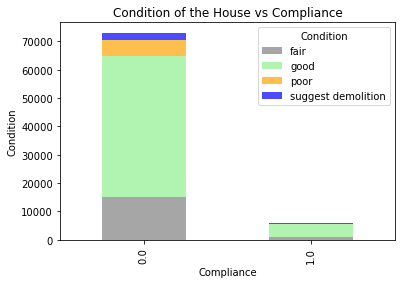

In [65]:
print(df.groupby(['compliance','Condition']).compliance.count().unstack())

#Condition class visualization
Condition_class = df.groupby(['compliance','Condition']).compliance.count().unstack()
p1 = Condition_class.plot(kind = 'bar', stacked = True, 
                   title = 'Condition of the House vs Compliance', 
                   color = ['grey','lightgreen','orange','blue'], alpha = .70)
p1.set_xlabel('Compliance')
p1.set_ylabel('Condition')
#plt.savefig('image/Condition_compliance.png')
plt.show()

Fire           no   yes
compliance             
0.0         68976  4084
1.0          5571   192


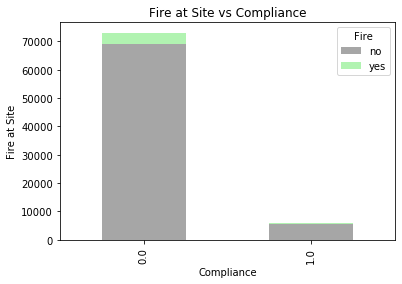

In [67]:
print(df.groupby(['compliance','Fire']).Fire.count().unstack())

#Fire class visualization
Fire_class = df.groupby(['compliance','Fire']).compliance.count().unstack()
p1 = Fire_class.plot(kind = 'bar', stacked = True, 
                   title = 'Fire at Site vs Compliance', 
                   color = ['grey','lightgreen',], alpha = .70)
p1.set_xlabel('Compliance')
p1.set_ylabel('Fire at Site')
#plt.savefig('images/Fire_Compliance.png')
plt.show()

Occupancy   maybe  occupied  unoccupied
compliance                             
0.0          3987     41012       28061
1.0           295      4025        1443


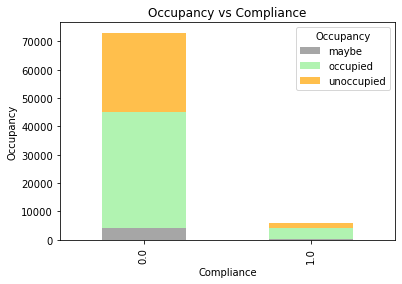

In [71]:
print(df.groupby(['compliance','Occupancy']).compliance.count().unstack())

#Condition class visualization
Occupancy_class = df.groupby(['compliance','Occupancy']).compliance.count().unstack()
p1 = Occupancy_class.plot(kind = 'bar', stacked = True, 
                   title = 'Occupancy vs Compliance', 
                   color = ['grey','lightgreen','orange'], alpha = .70)
p1.set_xlabel('Compliance')
p1.set_ylabel('Occupancy')
#plt.savefig('image/Occupancy_vs_compliance.png')
plt.show()

KeyError: 3.0

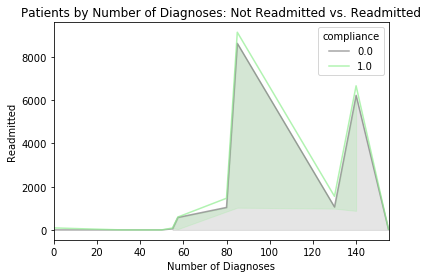

In [87]:
Jmnt = df.groupby(['judgment_amount','compliance']).compliance.count().unstack()

p1 = Jmnt.iloc[0:10, :].plot(kind = 'line', stacked = True, 
                   title = 'Patients by Number of Diagnoses: Not Readmitted vs. Readmitted', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Number of Diagnoses')
p1.set_ylabel('Readmitted')
plt.fill_between(Jmnt.iloc[0:10, :].index, Jmnt.iloc[0:10, :][0], color = 'gray', alpha = 0.2)
plt.fill_between(Jmnt.iloc[0:10, :].index, Jmnt.iloc[0:10, :][1] + Jmnt.iloc[0:9, :][1], Jmnt.iloc[0:10, :][0], color = 'lightgreen', alpha = 0.2)
plt.fill_between(Jmnt.iloc[0:10, :].index, 1 - Jmnt.iloc[0:10, :][3], 1, color = 'blue', alpha = 0.2)
p1.set_ylim(0.4, 1)
#plt.savefig('../image/Percentage_NoD_Readmitted.png')
plt.show()